In [46]:
import pandas as pd

In [47]:
ls 

Aerial-Cactus-Identification.ipynb  sample_submission.csv  test.zip  train.csv
README.md                           test/                  train/    train.zip


In [48]:
from glob import glob

In [49]:
train = glob('./train/*.jpg')

In [135]:
labeled_files = glob('./train/*.jpg')

In [50]:
print (train[:5])

['./train/d5c760870e3c9157ff95106180b2691f.jpg', './train/323583f9ad3a3e88785609c04dbca409.jpg', './train/d4f284c8820404bc4af320ecbb5c9b78.jpg', './train/b87b854e2e0400c0250ca962687b603a.jpg', './train/26b82b1c88e43b4663be2bf3efa60a1c.jpg']


In [51]:
df_train = pd.read_csv("train.csv")

In [52]:
df_train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [53]:
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.has_cactus.values)}
df_train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [54]:
X = df_train.id.values
y = df_train.has_cactus.values
print (type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [55]:
print (y[:100])

[1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1]


In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [136]:
train, val = train_test_split(labeled_files, test_size=0.1, random_state=42)

In [137]:
import matplotlib.pyplot as plt
import numpy as np

In [138]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from glob import glob
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imgaug import augmenters as iaa
import imgaug as ia

In [139]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1]

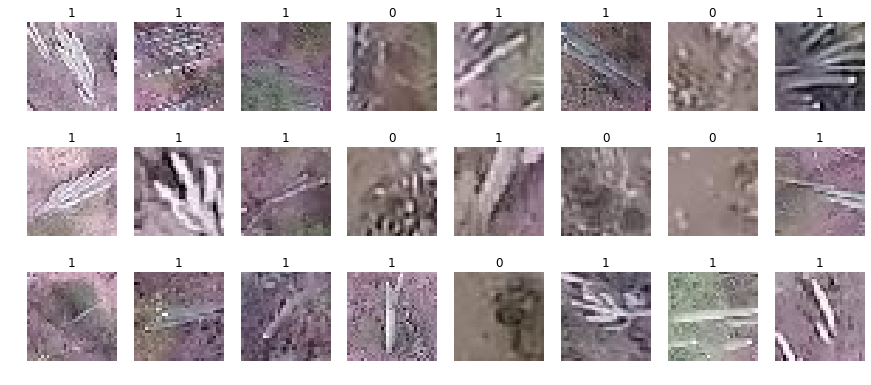

In [140]:
from PIL import Image
import os 
cols = 8
rows = 3
#pour allouer un cadre
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train))
        #on place chacune des images sur le cadre
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(Image.open(train[random_index]))
        ax.set_title(id_label_map[get_id_from_file_path(train[random_index])])
plt.show()

In [141]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_lst, y_lst, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=10, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.y = y_lst
        self.x = x_lst
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        X, y = __data_generation(indexes)
        
        return (X, y)
    
    def get_id_from_file_path(self, file_path):
        return file_path.split(os.path.sep)[-1]
    
    def get_seq(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        seq = iaa.Sequential(
            [
                # apply the following augmenters to most images
                iaa.Fliplr(0.5), # horizontally flip 50% of all images
                iaa.Flipud(0.2), # vertically flip 20% of all images
                sometimes(iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-10, 10), # rotate by -45 to +45 degrees
                    shear=(-5, 5), # shear by -16 to +16 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges,
                        # blend the result with the original image using a blobby mask
                        iaa.SimplexNoiseAlpha(iaa.OneOf([
                            iaa.EdgeDetect(alpha=(0.5, 1.0)),
                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                        ])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                            iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                        ]),
                        iaa.Invert(0.01, per_channel=True), # invert color channels
                        iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                        # either change the brightness of the whole image (sometimes
                        # per channel) or change the brightness of subareas
                        iaa.OneOf([
                            iaa.Multiply((0.9, 1.1), per_channel=0.5),
                            iaa.FrequencyNoiseAlpha(
                                exponent=(-1, 0),
                                first=iaa.Multiply((0.9, 1.1), per_channel=True),
                                second=iaa.ContrastNormalization((0.9, 1.1))
                            )
                        ]),
                        sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )
        return seq
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def read_and_resize(self, filepath):
        img = cv2.imread(filepath)
        res = resize(img, self.dim, preserve_range=True, mode='reflect')
        return np.expand_dims(res, 0)
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        print ('hello')
        seq = get_seq()
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        X = [self.read_and_resize(self.x[i])
             for i in indexes]
        Y = [self.id_label_map[get_id_from_file_path(self.x[ind])] for ind in indexes]
        X = np.vstack(X)
        return seq.augment_images(X), y
#         return (X, y)
#     def __data_generation(self, indexes):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         X = [self.read_and_resize(self.list_files[i])
#              for i in indexes]
#         Y = [self.id_label_map[get_id_from_file_path(self.list_files[ind])] for ind in indexes]
#         X = np.vstack(X)
#         return seq.augment_images(X), y
# #         return (X, y)

#     def __data_generation(self, batch):
#         seq = get_seq()
        
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)
        
        
#         X = [read_and_resize(self.x[ind]) for ind in batch]
#         Y = [self.y[ind] for ind in batch]
# #         X = seq.augment_images(X)
#         X = np.vstack(X)
#         X = [preprocess_input(x) for x in X]
#         return seq.augment_images(X), np.array(y)
# #         return (np.array(X), np.array(Y))

In [142]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)

In [143]:
# train, val = train_test_split(X, y/, test_size=0.1, random_state=101010)

In [144]:
params = {
            'dim': (96,96),
            'batch_size': 32,
            'n_classes': 2,
            'n_channels': 3,
            'shuffle': True
         }

training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_val, y_val, **params)

In [157]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def get_model_classif_nasnet():
    inputs = Input((32, 32, 3))
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.3


    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = inputs))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [158]:
model = get_model_classif_nasnet()

TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

In [159]:
batch_size = 32
h5_path = "model.h5"

checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

earlyStp = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')                              

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint, reduce_lr, earlyStp],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)
batch_size=64
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=18, verbose=1,
    callbacks=[checkpoint, reduce_lr, earlyStp],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)

model.load_weights(h5_path)


Epoch 1/2


ValueError: Error when checking input: expected conv2d_81_input to have shape (96, 96, 3) but got array with shape (32, 32, 3)